<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/quiz/Quiz-10.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

| **항목**               | **허용 여부**        | **비고**                                          |
|------------------------|----------------------|---------------------------------------------------|
| **강의노트 참고**      | 허용                 | 수업 중 제공된 강의노트나 본인이 정리한 자료를 참고 가능       |
| **구글 검색**          | 허용                 | 인터넷을 통한 자료 검색 및 정보 확인 가능        |
| **생성 모형 사용**           | 허용           | 인공지능 기반 도구(GPT 등) 사용 가능            |

{{< https://youtu.be/playlist?list=PLQqh36zP38-yUpqrBWvOS8WPHNW4fk9cn&si=ZDoDd-zn6wSS8Op2 >}}

In [1]:
import os
os.environ["WANDB_MODE"] = "offline"

In [2]:
import pandas as pd
import numpy as np
import datasets 
import transformers
import torch
import torch.utils
import PIL.Image
import io

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. `imdb` -- 40점

아래의 코드를 실행하여 `model`, `imdb` 을 불러오라. 

In [6]:
imdb = datasets.load_dataset("guebin/imdb-tiny")
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2
)
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
imdb = imdb.map(preprocess_function,batched=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`???`에 적절한 `collate_fn` 을 설계하여 아래의 코드를 완성하라.

```Python
trainer = transformers.Trainer(
    model=model,
    data_collator=???,
    train_dataset=imdb['train']
)
trainer.train()
```

**제약사항**

1. `DataCollatorWithPadding`을 사용하지 말고 수동구현 할 것
2. `batch_maker`를 이용한 검증코드를 제시할 것 

`(풀이1)`

In [8]:
trainer = batch_maker = transformers.Trainer(
    model=model,
    data_collator=lambda x: x,
    train_dataset=imdb['train']
)

In [15]:
single_batch = next(iter(batch_maker.get_eval_dataloader(imdb['train'])))
def collate_fn(single_batch):
    collated_data = dict()
    collated_data['input_ids'] = torch.nn.utils.rnn.pad_sequence([torch.tensor(dct['input_ids']) for dct in single_batch]).t()    
    collated_data['attention_mask'] = torch.nn.utils.rnn.pad_sequence([torch.tensor(dct['attention_mask']) for dct in single_batch]).t()
    collated_data['labels'] = torch.tensor([dct['label'] for dct in single_batch])
    return collated_data
model.to("cpu")
model(**collate_fn(single_batch))

SequenceClassifierOutput(loss=tensor(0.6894, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0484,  0.0165],
        [ 0.0187,  0.0715],
        [ 0.0006,  0.0235],
        [ 0.0460,  0.0185],
        [ 0.0360,  0.0242],
        [ 0.0357,  0.0588],
        [ 0.0615, -0.0133],
        [ 0.0319,  0.0157]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [21]:
trainer.data_collator = collate_fn

In [22]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=6, training_loss=0.4297721783320109, metrics={'train_runtime': 1.4264, 'train_samples_per_second': 21.033, 'train_steps_per_second': 4.207, 'total_flos': 3663551494080.0, 'train_loss': 0.4297721783320109, 'epoch': 3.0})

`(풀이2)`

In [26]:
batch_maker = transformers.Trainer(
    model=model,
    data_collator=lambda x: x,
)
_batched_data = batch_maker.get_eval_dataloader(imdb['train'])
batched_data = list(_batched_data)
single_batch = batched_data[-1]
def collate_fn(single_batch):
    collated_data = dict()
    collated_data['input_ids'] = torch.nn.utils.rnn.pad_sequence([torch.tensor(dct['input_ids']) for dct in single_batch]).t()    
    collated_data['attention_mask'] = torch.nn.utils.rnn.pad_sequence([torch.tensor(dct['attention_mask']) for dct in single_batch]).t()
    collated_data['labels'] = torch.tensor([dct['label'] for dct in single_batch])
    return collated_data
model.to("cpu")
model(**collate_fn(single_batch))

SequenceClassifierOutput(loss=tensor(0.2261, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.6386, -0.8341],
        [ 0.6473, -0.6306]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [28]:
trainer = transformers.Trainer(
    model=model,
    data_collator=collate_fn,
    train_dataset=imdb['train']
)
trainer.train()

Step,Training Loss


TrainOutput(global_step=6, training_loss=0.09632491072018941, metrics={'train_runtime': 1.265, 'train_samples_per_second': 23.716, 'train_steps_per_second': 4.743, 'total_flos': 3663551494080.0, 'train_loss': 0.09632491072018941, 'epoch': 3.0})

# 2. `Food101` -- 60점

> (1)번 20점, (2)번 40점

`(1)` 아래의 코드를 실행하여 `food_pandas` 를 불러오라. 

In [44]:
food_pandas = pd.read_parquet("hf://datasets/guebin/food101-tiny/data/train-00000-of-00001.parquet")

`food_pandas`를 활용하여 아래와 같은 `food`를 만들어라. 

In [36]:
food

Dataset({
    features: ['image', 'label', 'PILImage'],
    num_rows: 10
})

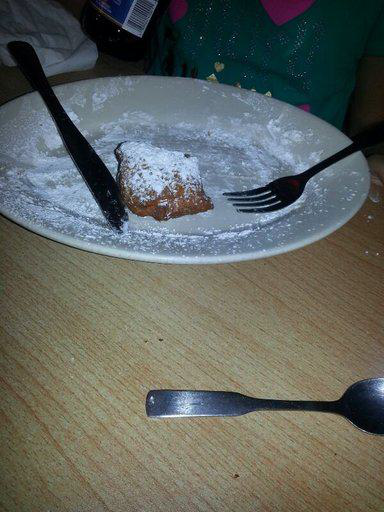

In [163]:
food[0]['PILImage']

`(풀이)`

In [58]:
food = datasets.Dataset.from_pandas(food_pandas)
food = food.map(lambda dct: {'PILImage': PIL.Image.open(io.BytesIO(dct['image']['bytes']))})
food

Map: 100%|██████████████████████████████| 10/10 [00:00<00:00, 121.90 examples/s]


Dataset({
    features: ['image', 'label', 'PILImage'],
    num_rows: 10
})

In [65]:
food['PILImage'][:2]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>]

`(2)` 아래의 코드를 실행하여 `model`과 `image_processor`를 불러오라.

In [29]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=101
)
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


`image_processor` 를 이용하여 (1)에서 만든 `food`의 이미지를 전처리하고, `???`에 적절한 `data_collator` 혹은 `collate_fn` 을 설계하여 아래의 코드를 완성하라.

```Python
trainer = transformers.Trainer(
    model=model,
    data_collator=???,
    train_dataset=food
)
trainer.train()
```

**제약사항**

1. `food`에 추가적인 전처리를 하지 말 것. (`food.map()`, `food.with_transform()`을 하지 말 것)
2. `image_processor` 이외의 방법으로 전처리 하지 말 것. (즉 `torchvision.transform`의 기능을 이용하지 말 것)
3. `batch_maker`를 이용한 검증코드를 제시할 것 

`(풀이1)`

In [70]:
trainer = batch_maker = transformers.Trainer(
    model = model,
    data_collator = lambda x: x,
    train_dataset = food,
)
trainer.args.remove_unused_columns = False
single_batch = list(batch_maker.get_eval_dataloader(food))[-1]
def collate_fn(single_batch):
    collated_data = dict() 
    collated_data['pixel_values'] = torch.tensor(np.stack(image_processor([o['PILImage'] for o in single_batch])['pixel_values']))
    collated_data['labels'] = torch.tensor([o['label'] for o in single_batch])
    return collated_data
model.to("cpu")
model(**collate_fn(single_batch))

ImageClassifierOutput(loss=tensor(4.0448, grad_fn=<NllLossBackward0>), logits=tensor([[-1.2451e-01, -1.7136e-01, -1.9260e-01, -1.0890e-01, -2.0196e-01,
          1.0828e-01,  5.3339e-01, -1.3210e-01, -7.2697e-02, -1.7969e-01,
         -2.2034e-02,  7.4470e-02, -8.1163e-02,  1.0383e-01, -1.0388e-01,
         -5.3669e-02, -1.1131e-02,  6.4546e-03,  4.4348e-02,  4.0024e-02,
         -1.0133e-01,  1.2939e-01, -1.5351e-01, -3.1243e-02, -2.5516e-01,
         -7.4038e-02, -6.5681e-02, -9.0420e-02,  5.4907e-02, -1.7349e-02,
         -7.5726e-02, -1.3857e-01,  1.2995e-01, -1.7233e-01,  7.2093e-02,
         -7.0481e-02,  7.9041e-03,  8.9555e-02,  9.1321e-02,  1.2188e-01,
         -4.5204e-02,  1.1487e-01, -2.3146e-01, -4.0090e-02, -1.4442e-01,
          3.4015e-02,  3.2219e-02, -2.0292e-01, -5.0452e-02, -1.0275e-01,
         -1.8033e-02,  1.0946e-01,  2.1242e-02,  1.0259e-01, -1.6825e-01,
         -8.0927e-02, -1.9911e-01,  5.6908e-02, -1.9366e-01,  5.4167e-03,
         -1.3510e-01,  6.8766e-02,

In [71]:
trainer.data_collator = collate_fn
trainer.train()

Step,Training Loss


TrainOutput(global_step=6, training_loss=3.661321004231771, metrics={'train_runtime': 1.5054, 'train_samples_per_second': 19.928, 'train_steps_per_second': 3.986, 'total_flos': 2326822460928000.0, 'train_loss': 3.661321004231771, 'epoch': 3.0})

`(풀이2)`

In [72]:
batch_maker = transformers.Trainer(
    model = model,
    data_collator = lambda x: x,
    train_dataset = food,
    args = transformers.TrainingArguments(
        output_dir="asdf",
        remove_unused_columns=False
    )
)
single_batch = list(batch_maker.get_eval_dataloader(food))[-1]
def collate_fn(single_batch):
    collated_data = dict() 
    collated_data['pixel_values'] = torch.tensor(np.stack(image_processor([o['PILImage'] for o in single_batch])['pixel_values']))
    collated_data['labels'] = torch.tensor([o['label'] for o in single_batch])
    return collated_data
model.to("cpu")
model(**collate_fn(single_batch))

ImageClassifierOutput(loss=tensor(3.2432, grad_fn=<NllLossBackward0>), logits=tensor([[-1.8510e-01, -1.9999e-01, -9.5537e-02, -9.0041e-02, -2.2867e-01,
         -1.2575e-02,  1.3140e+00, -1.2839e-01, -3.0236e-02, -2.5974e-01,
         -7.4725e-02,  6.1918e-03, -1.6538e-02,  1.6465e-01, -2.6724e-02,
         -2.7049e-02,  4.3340e-02,  8.9233e-02,  9.9222e-02, -1.5289e-01,
         -1.2641e-01,  1.3453e-01, -8.2606e-02, -5.3130e-02, -2.6672e-01,
         -2.0686e-01,  1.1107e-02, -9.7890e-02, -3.2137e-02,  2.3901e-02,
         -1.7500e-01, -8.0506e-02,  1.8472e-01, -1.3049e-01,  2.8494e-02,
         -9.1536e-02, -1.0137e-01,  1.9131e-02,  1.5325e-01, -5.3265e-02,
         -1.0158e-01,  1.5654e-01, -2.4823e-01, -1.2814e-01, -2.1389e-01,
         -5.3225e-02, -4.7214e-02, -3.0080e-01, -1.1903e-01, -5.0342e-02,
         -7.7965e-02,  6.4922e-02,  1.8810e-02, -1.1921e-02, -1.4526e-01,
         -1.2815e-01, -3.7510e-01, -1.7370e-01, -2.6114e-01,  3.4536e-02,
          1.0942e-01,  5.5211e-02,

In [74]:
trainer = transformers.Trainer(
    model = model,
    data_collator = collate_fn,
    train_dataset = food,
    args = transformers.TrainingArguments(
        output_dir="asdf",
        remove_unused_columns=False
    )
)
trainer.train()

Step,Training Loss


TrainOutput(global_step=6, training_loss=2.512084643046061, metrics={'train_runtime': 1.3329, 'train_samples_per_second': 22.507, 'train_steps_per_second': 4.501, 'total_flos': 2326822460928000.0, 'train_loss': 2.512084643046061, 'epoch': 3.0})